In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
import data.data_utils as dutils

In [2]:
nsigs=4
ndisc=2
nrand=2
nj_train   = 5000
nj_valid   = 5
nj_testy   = 5000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)

 Mins: [0, 0, 0.22891119493276602, 0.44032193938454656] 
 Maxs: [1, 1, 0.9848607691234481, 0.6293942480439525] 
 Peaks: [0.05, 0.95, 0.601467533779156, 0.5762395779893448]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.40it/s]


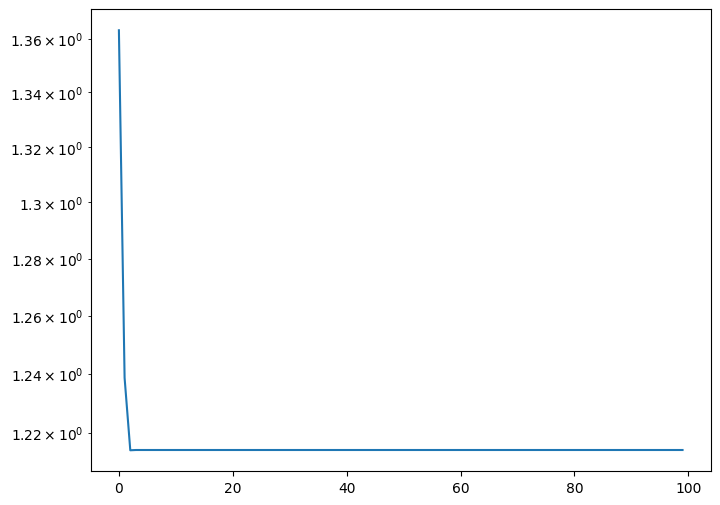

4
Accuracy: tensor(0.4531)


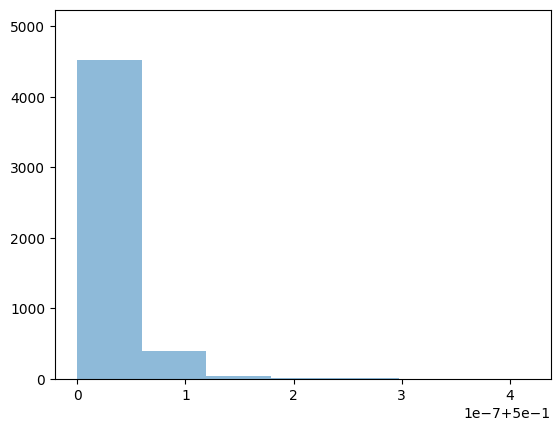

4
Accuracy: tensor(0.4673)


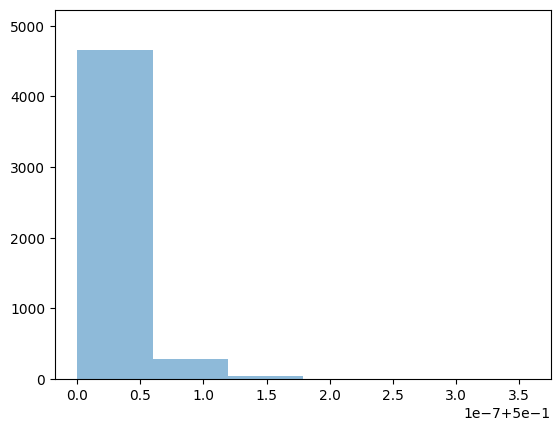

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


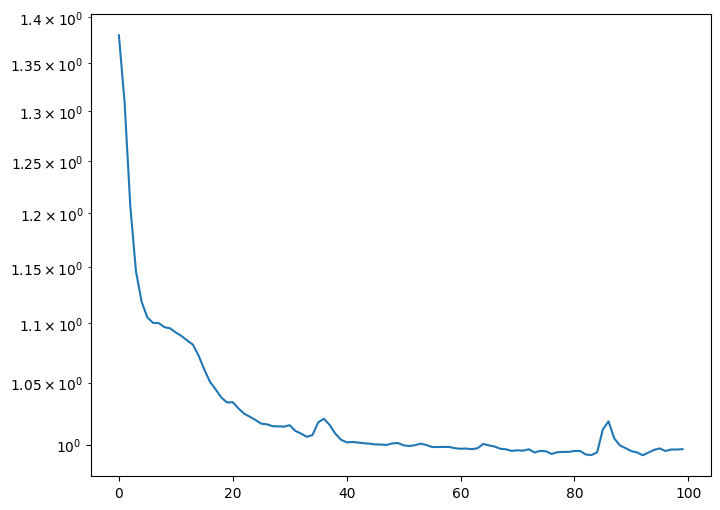

4
Accuracy: tensor(0.2007)


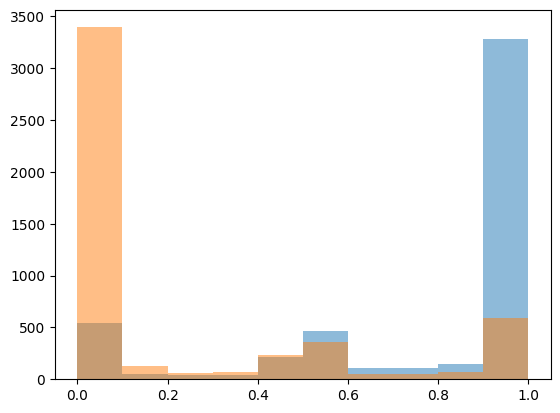

In [3]:
#Supervised training examples
input_dim  = tjds.train_data.shape[1]
last_dim=16
batch_size=2000
disc_trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model=dutils.train_disc(100,disc_trainloader,input_dim,last_dim,output_dim=nsigs)
plt.show()
dutils.check_disc(tjds.test_data,tjds.test_labels,disc_model)
plt.show()
dutils.check_disc(tjds.trut_data,tjds.trut_labels,disc_model)
plt.show()

disc_trainloader = torch.utils.data.DataLoader(tjds.true_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model_data=dutils.train_disc(100,disc_trainloader,input_dim,last_dim,output_dim=nsigs)
plt.show()
dutils.check_disc(tjds.trut_data,tjds.trut_labels,disc_model_data)

plt.show()

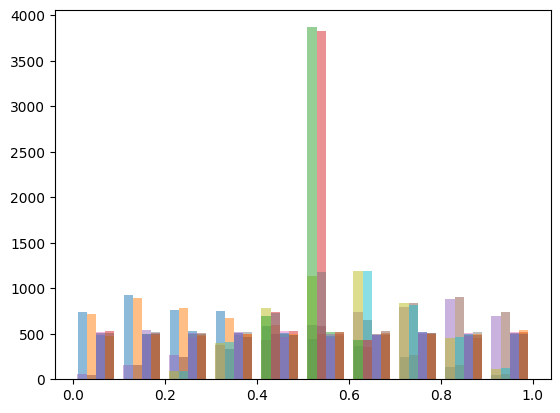

In [4]:
#plot the data
label=tjds.train_labels
#print(len(label[label==1]),len(tjds.train_data[label==0]))
plt.hist(tjds.train_data[label==0],alpha=0.5)
plt.hist(tjds.train_data[label==1],alpha=0.5)
plt.hist(tjds.train_data[label==2],alpha=0.5)
plt.hist(tjds.train_data[label==3],alpha=0.5)
plt.show()

In [8]:
#now contrastive model
hidden_dims= [128,64,32,16]
embed_dim  = 2 #not making it smaller than input space
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:21<00:00,  1.01s/it]


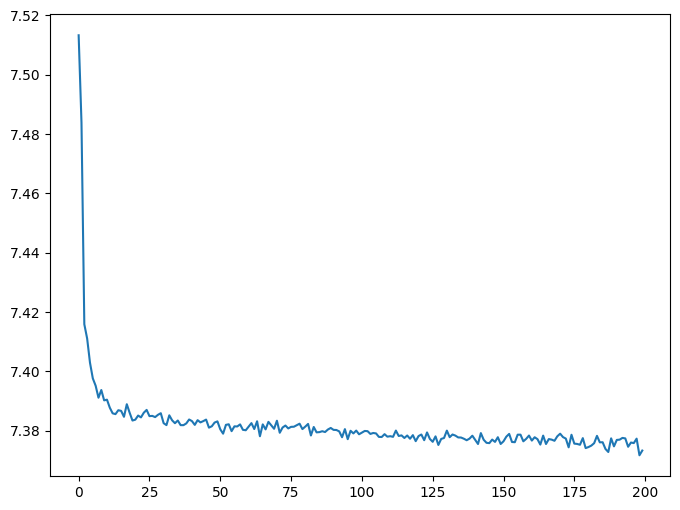

In [9]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

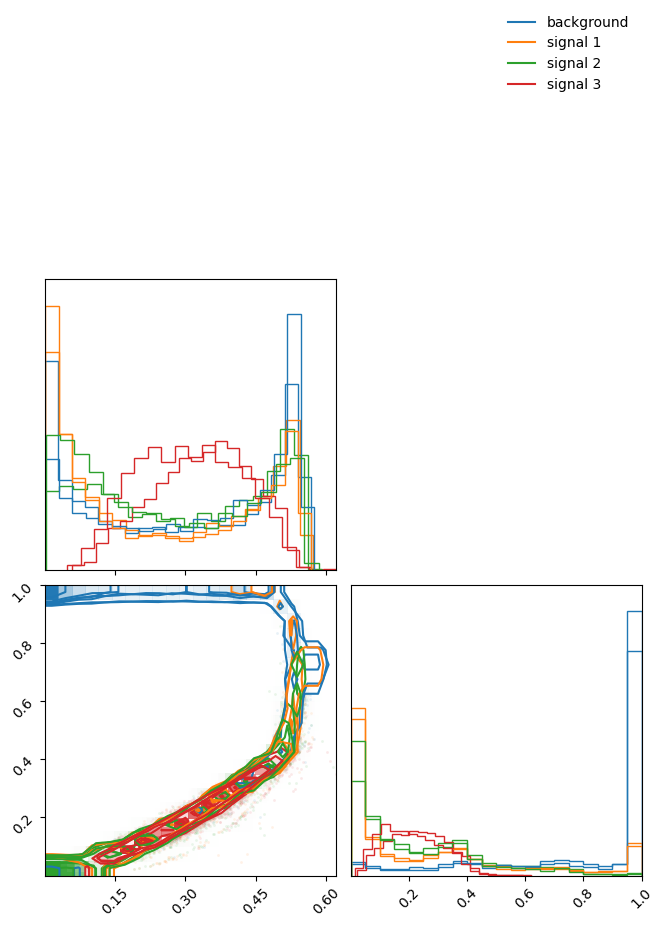

In [10]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


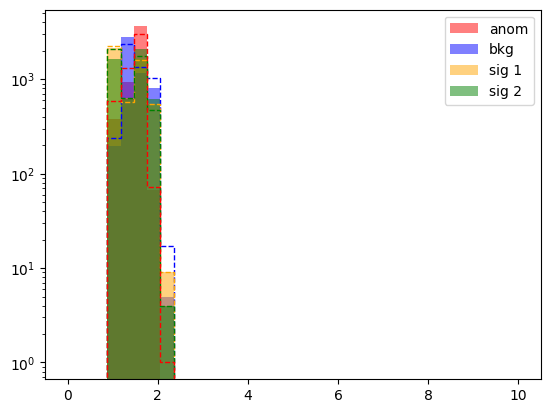

AUC: tensor(0.6291)


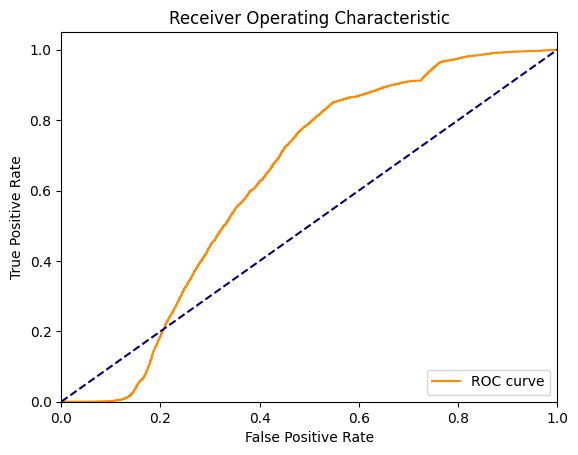

AUC: tensor(0.5898)


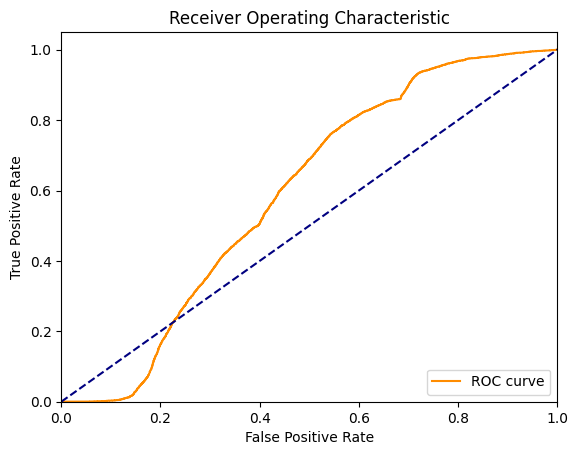

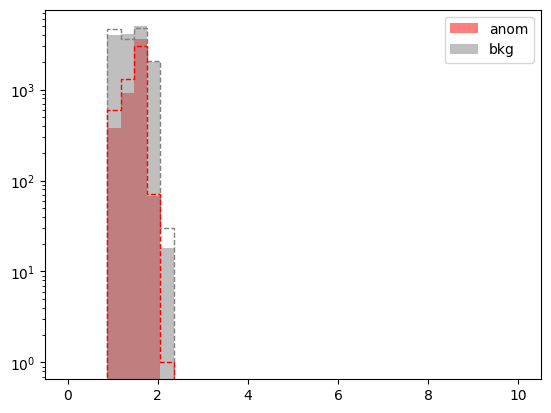

In [11]:
#Phil's simplified manahalobis distance
dist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


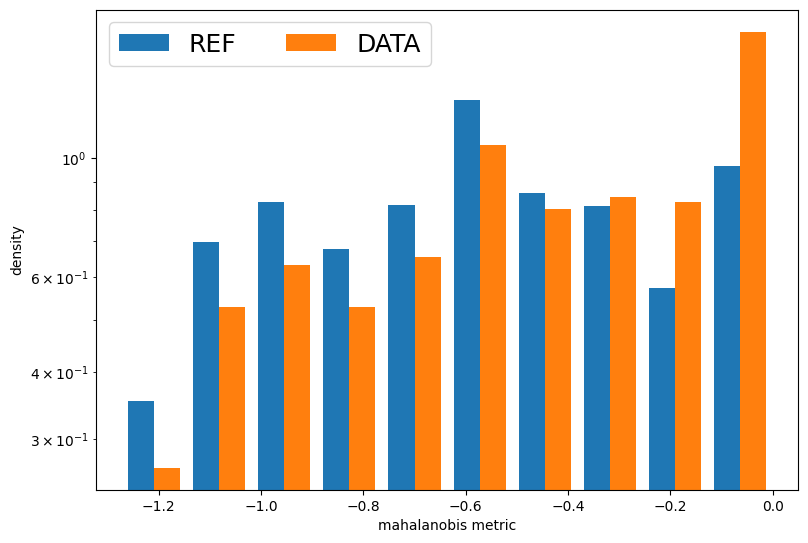

Mahalanobis test:  9836.507812


In [17]:
ref=output[labels != (nsigs-1)]
ref_label=label[labels != (nsigs-1)]
dist=dutils.mahalanobis_dist(output,ref,ref_label)


[1.645 2.33 ] [1.0, 1.0] [(1.0, 0.01816, -0.00174), (1.0, 0.01816, -0.00174)]


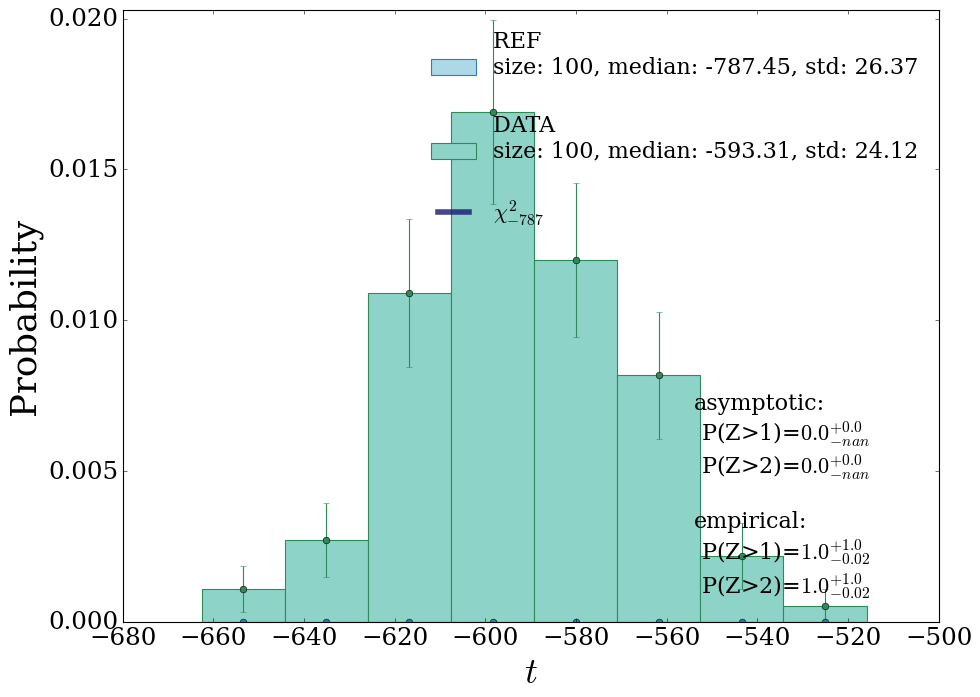

([array([1.645, 2.33 ]),
  [1.0, 1.0],
  [(1.0, 0.01816, -0.00174), (1.0, 0.01816, -0.00174)]],
 [array([1.645, 2.33 ]), [0.0, 0.0], [(0.0, nan, nan), (0.0, nan, nan)]])

In [56]:
dutils.run_toy(1000, 1000, 10000, output,labels,output,labels,3)

In [9]:
embedder_full   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector_full  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model_full = SimCLRModel(embedder_full, projector_full)
criterion_full = SupervisedSimCLRLoss(temperature=temp)
optimizer_full = torch.optim.AdamW(model_full.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:34<00:00,  1.67s/it]


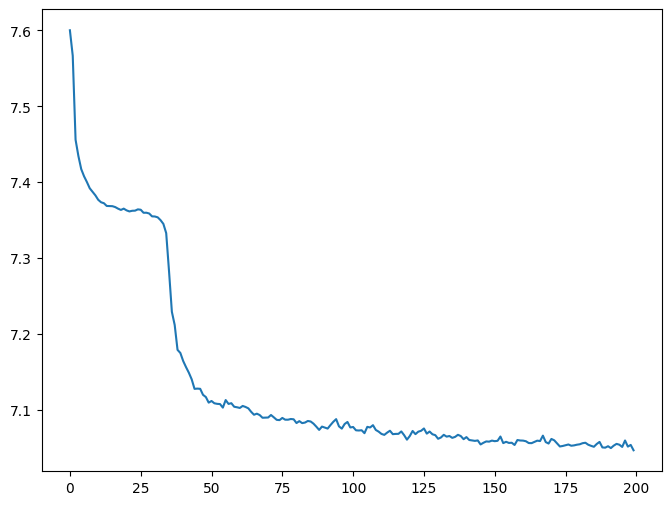

In [10]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader_full = torch.utils.data.DataLoader(tjds.train_dataset_basic_full, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader_full,model_full,criterion_full,optimizer_full)

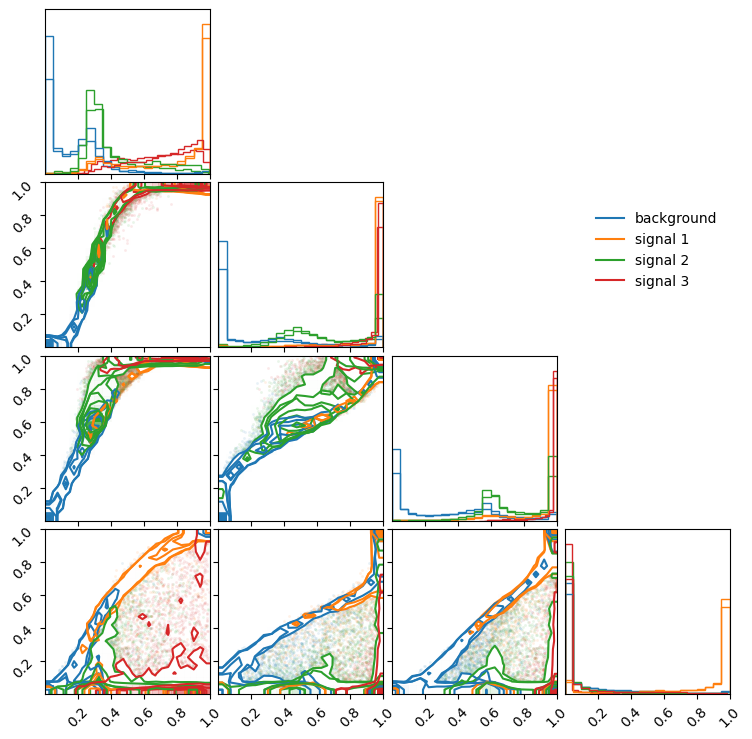

In [11]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model_full(tjds.test_data.float(),embed=True))
    output1 = (model_full(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


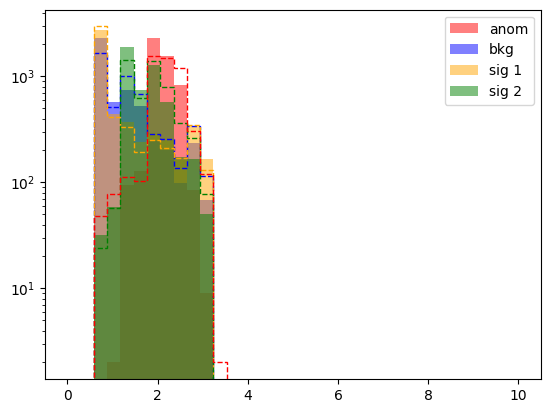

AUC: tensor(0.8278)


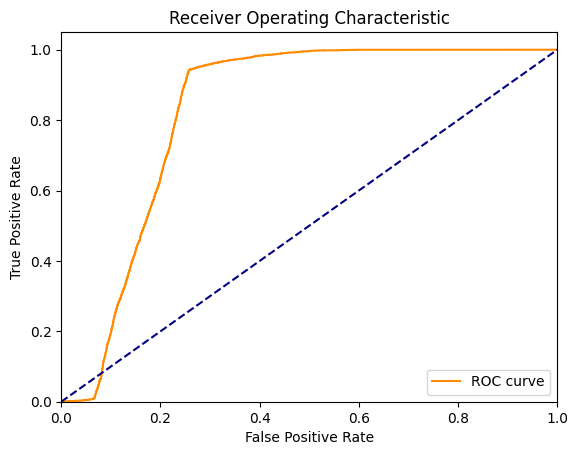

AUC: tensor(0.8011)


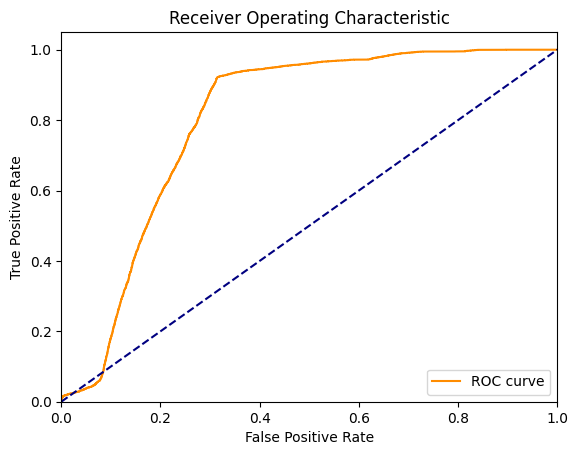

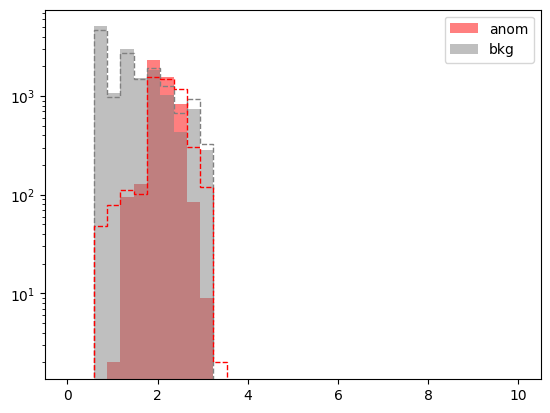

In [12]:
dist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


In [25]:
nsigs=4
ndisc=4
nrand=0
nj_train   = 20000
nj_valid   = 5
nj_testy   = 20000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)

 Mins: [0, 0, 0.07696627150179669, 0.3386658078952267] 
 Maxs: [1, 1, 0.9312748153680579, 0.7706797984203926] 
 Peaks: [0.05, 0.95, 0.2655634084918845, 0.7084932372737425]


In [26]:
input_dim  = tjds.train_data.shape[1]
hidden_dims= [128,64,32,16]
embed_dim  = 4
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:32:58<00:00, 27.89s/it]


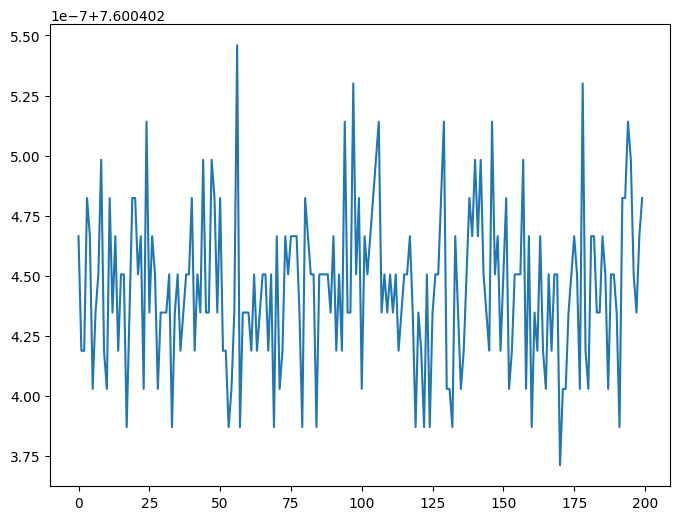

In [27]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

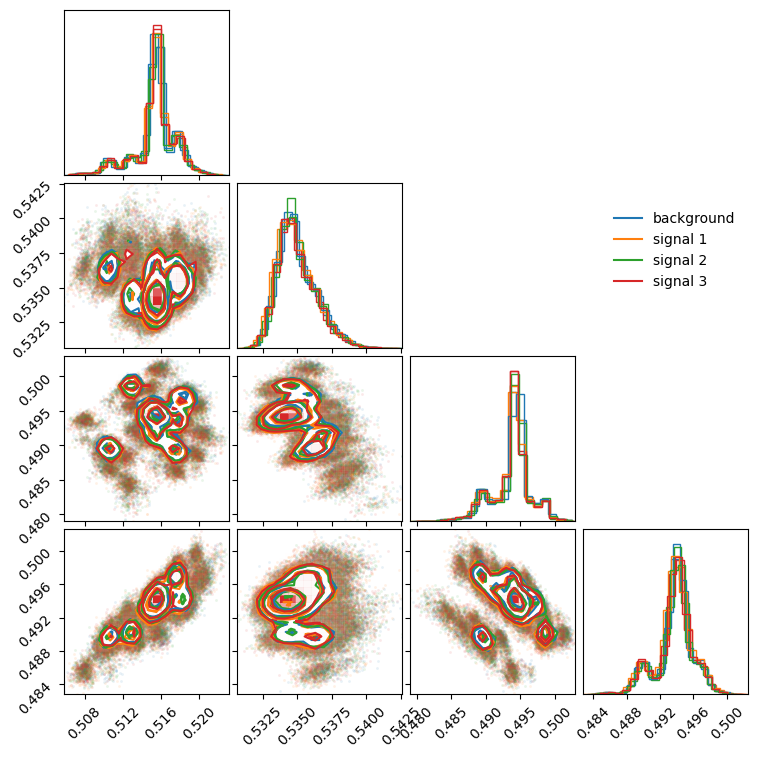

In [28]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


In [29]:
ist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


IndexError: The shape of the mask [80000] at index 0 does not match the shape of the indexed tensor [20000] at index 0

In [ ]:
embedder_full   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector_full  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model_full = SimCLRModel(embedder_full, projector_full)
criterion_full = SupervisedSimCLRLoss(temperature=temp)
optimizer_full = torch.optim.AdamW(model_full.parameters(), lr=0.5e-2)

In [ ]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

In [ ]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model_full(tjds.test_data.float(),embed=True))
    output1 = (model_full(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


In [ ]:
dist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


In [23]:
nsigs   = np.random.poisson(lam=30, size=100)
print(nsigs)
sigidx  = np.random.choice(5000, size=nsigs, replace=False)
print(sigidx)

[27 36 26 39 26 32 30 23 23 28 28 21 33 28 28 28 34 23 34 28 30 26 30 35
 18 28 30 31 29 32 26 28 25 31 24 32 25 31 38 21 27 35 37 17 25 31 33 31
 28 25 31 34 36 35 27 33 30 27 31 37 23 31 21 31 34 37 36 23 30 26 26 19
 27 30 31 33 29 30 24 40 39 23 36 20 30 34 31 35 32 25 34 35 33 33 34 26
 49 25 29 30]


ValueError: maximum supported dimension for an ndarray is 32, found 100